In [30]:
import bqplot as bq
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from scipy.stats import norm, lognorm

import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')

In [2]:
def import_image(image_path):
    """Import the image of the plot"""
    with open(image_path, 'rb') as fid:
        raw_img = fid.read()

    ipyimg = widgets.Image(value=raw_img, format=image_path[-3:])
    return ipyimg


def set_image_dim(x_dim, y_dim):
    """Set the scale of the plot, i.e. min/max x, min/max y"""

    scales = {'x': bq.LinearScale(min=np.min(x_dim), max=np.max(x_dim)),
              'y': bq.LinearScale(min=np.min(y_dim), max=np.max(y_dim))}

    return scales


def add_del(scale, img):
    """Add function for ipywidget buttons to add and delete points"""

    scat = bq.Scatter(x=[], y=[], scales=scale, colors=['black'],
                      enable_move=True)

    image = bq.Image(x=np.array([scale['x'].min, scale['x'].max]),
                     y=np.array([scale['y'].min, scale['y'].max]),
                     image=img, scales=scale, enable_hover=False)

    interact_control = widgets.ToggleButtons(options=['Add', 'Delete'],
                                             style={'button_width': '130px',
                                                   'button_style': 'warning'})

    def change_interact(shape):
        """Give a meaning to the buttons."""
        interact_params = {
            'Add': {'interactions': {'click': 'add'},
                    'enable_move': True},
            'Delete': {'interactions': {'click': 'delete'},
                       'enable_move': False}
        }

        for param, value in interact_params[interact_control.value].items():
            setattr(scat, param, value)
    interact_control.observe(change_interact)

    fig = bq.Figure(title='Plot Temp vs Powerdensity', marks=[image, scat],
                    padding_x=0, padding_y=0)
    fig.axes = [bq.Axis(scale=scale['x']), bq.Axis(scale=scale['y'],
                                                   orientation='vertical')]

    return widgets.VBox([fig, interact_control])
    # return widgets.HBox([widgets.VBox([fig, interact_control]),
    #                    print(scat.x, scat.y)])

def write_data(fig, profile_direction: str = 'x', formation: str = 'basement') -> pd.DataFrame:
    """Write picked data to a dataframe

    Args:
        fig (widget): widget object with coordinate data
        profile_direction (string, optional): direction of profile. If 'x', 'y' will be set
        to 1, if 'y', 'x' will be set to one. Defaults to 'x'.
        formation (string, optional): Name of picked formation. Defaults to 'basement'.
    """
    
    x = fig.children[0].marks[1].x
    y = fig.children[0].marks[1].y
        
    df_dict = {'Temp[Celsius]':x, 'PowerDens [MW/sqkm]':y}
    df = pd.DataFrame.from_dict(df_dict)
    
    return df

## Import the Image and set its dimensions

In [3]:
img = import_image('../figures/wilmarth_2019_noborders.PNG')

In [4]:
xdim = np.array([75., 350.]) # temperature from 75 °C to 350 °C
ydim = np.array([0., 45.]) # PowerDensity in MW per square km
dimensions = set_image_dim(xdim, ydim)

In [5]:
# create figure object
click_fig = add_del(dimensions, img)

In [6]:
click_fig

In [39]:
img_output = write_data(click_fig)

In [40]:
img_output

,Temp[Celsius],PowerDens [MW/sqkm]
0,279.927510,14.661428
1,277.665022,31.375713


In [41]:
lowerPD, higherPD = np.array([img_output['PowerDens [MW/sqkm]'].argmin(),
                     img_output['PowerDens [MW/sqkm]'].argmax()])

# Hannah's implementation

In [42]:
# USER INPUT REQUIRED
Ptemp = 0.8
Pperm = 0.65
Pchem = 0.9

POSexpl = Ptemp * Pperm * Pchem
print("Probability of exploration success = {:.0f}%".format(POSexpl*100))
# Could potentially code in user option to adjust number of decimal places for POS

Probability of exploration success = 47%


In [43]:
# USER INPUT REQUIRED
#Cumulative confidence of optimistic case
Opt_case = 0.1

In [44]:
# USER INPUT REQUIRED
Tmax_P90 = np.mean(img_output['Temp[Celsius]']) #startup averages temperature for P90 reserves (degrees C)
Tmin = 250 #minimum temperature for the P10 reservoir (degrees C)
print("Startup temperature P90 {:.2f} °C, \nMin temperature for P10 {:.2f} °C".format(*[Tmax_P90,Tmin]))

Startup temperature P90 278.80 °C, 
Min temperature for P10 250.00 °C


In [45]:
# USER INPUT REQUIRED
# Power Density 250 to 280 deg C (MWe/km2)
PowerDens_P90 = img_output['PowerDens [MW/sqkm]'].iloc[lowerPD]
PowerDens_P10 = img_output['PowerDens [MW/sqkm]'].iloc[higherPD]

In [46]:
# USER INPUT REQUIRED
# Area > 250 deg C in km2
Area_P90 = 1
Area_P10 = 10

In [47]:
# Calculate nu and sigma for area > 250 degC (the mean and variance in log units required for specifying lognormal distributions)
area_nu = ((np.log(Area_P90)+np.log(Area_P10))/2)
print("Mean area is {:.4f} km²".format(area_nu))

area_sigma = (np.log(Area_P10)-np.log(Area_P90))/((norm.ppf(1-Opt_case)-(norm.ppf(Opt_case))))
print("Variance of area is {:.4f} km²$".format(area_sigma))

Mean area is 1.1513 km²
Variance of area is 0.8984 km²$


In [48]:
# Calculate nu and sigma for power density (the mean and variance in log units required for specifying lognormal distributions)
powerdens_nu = ((np.log(PowerDens_P90)+np.log(PowerDens_P10))/2)
print("Mean power density is {:.4f}".format(powerdens_nu))

powerdens_sigma = (np.log(PowerDens_P10)-np.log(PowerDens_P90))/((norm.ppf(1-Opt_case)-(norm.ppf(Opt_case))))
print("Variance of power density is {:.4f}".format(powerdens_sigma))

Mean power density is 3.0656
Variance of power density is 0.2968


In [49]:
# Calculate nu and sigma for MWe Capacity
capacity_nu = area_nu + powerdens_nu
print("Mean capacity is {:.4f} MWe".format(capacity_nu))

capacity_sigma = ((area_sigma**2)+(powerdens_sigma**2))**0.5
print("Variance capacity is {:.4f} MWe".format(capacity_sigma))

Mean capacity is 4.2169 MWe
Variance capacity is 0.9461 MWe


In [50]:
# Calculate cumulative confidence curve for expected power capacity (epc)

prob = [0.1]
expected_power_capacity=[]
expected_development_size=[]
prob_desc = []

# Specify probability range
for i in range(1,100):
    prob.append(i)

for j in prob:
    # Calculate expected development size distribution
    eds = lognorm.ppf(j/100, capacity_sigma, loc=0, scale=np.exp(capacity_nu))
    expected_development_size.append(eds)
    # Calculate power capacity distribution
    epc = eds*POSexpl
    expected_power_capacity.append(epc)
    # Calculate 100-prob for plotting descending cumulative probability
    desc = 100-j
    prob_desc.append(desc)
    # Print results

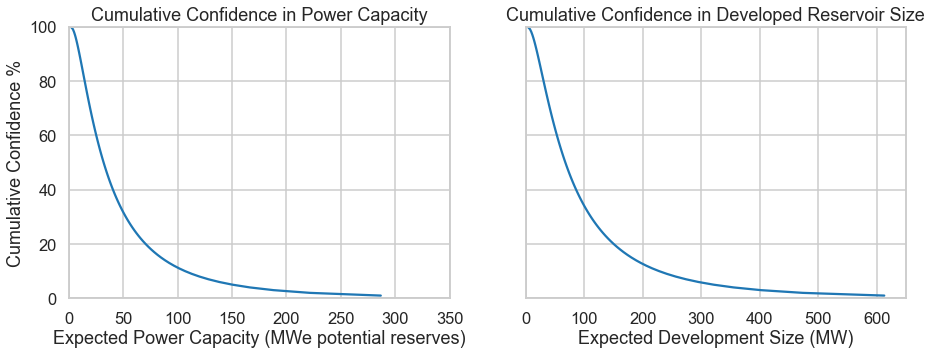

In [51]:
# Plot it
fig, axs = plt.subplots(1,2, figsize=[15, 5], sharey=True)

# Plot power capacity cumulative distribution
axs[0].plot(expected_power_capacity, prob_desc)
axs[0].set_xlabel("Expected Power Capacity (MWe potential reserves)")
axs[0].set_ylabel("Cumulative Confidence %")
axs[0].set_title("Cumulative Confidence in Power Capacity")
axs[0].set_xlim([0, 350])
axs[0].set_ylim([0, 100])

# Plot expected development size cumulative distribution
axs[1].plot(expected_development_size, prob_desc)
axs[1].set_xlabel("Expected Development Size (MW)")
axs[1].set_title("Cumulative Confidence in Developed Reservoir Size")
axs[1].set_xlim([0, 650])
axs[1].set_ylim([0, 100]);